In [1]:
import pandas as pd
import georinex as gr
import misc
from plots import *
import matplotlib.dates as mdates
import datetime
import matplotlib
import copy

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader, PosReader, RinexReader

# Prepare the data

In [2]:
# Load log files
measurements_log = ['Raw', 'Fix']
#measurements_RINEX = ['C1C']
measurements_RINEX = sum([[f"{y}{x}" for y in ['C', 'L', 'D', 'S']] for x in ['1C', '1L', '5Q', '2I', '5P', '5A']], [])
logs = []

log = LogReader(manufacturer="Google", device="Pixel 7", acronym='GP7', specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_GooglePixel7_20230217095501.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230480000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

log = LogReader(manufacturer="Google", device="Pixel Watch", acronym='GPW', specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_GooglePixelWatch_20230814145154_modified.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20232260000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

log = LogReader(manufacturer="OnePlus", device="Nord 2", acronym='ON2', specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_OnePlusNord2_20230303105504.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230620000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

log = LogReader(manufacturer="Samsung", device="A52", acronym='A52', specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_SamsungA52_20230317141230.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230760000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

log = LogReader(manufacturer="Xiaomi", device="11T", acronym='X11', specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_Xiaomi11_20230303095606.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230620000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

device_list = [log.device for log in logs]

In [3]:
# Output folder
output = '../.output/S1'

In [4]:
logs[0].raw.prn.unique()

array(['G15-L1', 'G23-L1', 'G30-L1', 'G23-L5', 'G30-L5', 'C21-L1',
       'C26-L1', 'C30-L1', 'C40-L1', 'C45-L1', 'C24-L5', 'C29-L5',
       'C33-L5', 'C42-L5', 'E03-L1', 'E09-L1', 'E24-L1', 'E26-L1',
       'E03-L5', 'E09-L5', 'E24-L5', 'E26-L5', 'G08-L1', 'G17-L1',
       'G24-L1', 'G08-L5', 'G24-L5', 'R13-L1', 'C24-L1', 'C29-L1',
       'C33-L1', 'C42-L1', 'C21-L5', 'C26-L5', 'C30-L5', 'C40-L5',
       'C45-L5', 'E05-L1', 'E13-L1', 'E25-L1', 'E31-L1', 'E05-L5',
       'E13-L5', 'E25-L5', 'E31-L5', 'G13-L1', 'R14-L1', 'R04-L1',
       'G14-L1', 'G14-L5', 'C10-L1', 'G10-L1', 'G10-L5', 'G21-L1',
       'J195-L1', 'J195-L5', 'E33-L1', 'E33-L5', 'R05-L1', 'G19-L1'],
      dtype=object)

In [5]:
logs[0].raw.loc[logs[0].raw['prn'].isin(['J195-L1']), ['TimeNanos', 'AccumulatedDeltaRangeMeters', 'PhaseVelocity', 'PhaseError']]


,TimeNanos,AccumulatedDeltaRangeMeters,PhaseVelocity,PhaseError
datetime,,,,
2023-02-17 08:18:24.000,1.542736e+12,4.496730,NaN,NaN
2023-02-17 08:18:25.000,1.543736e+12,4.499988,0.003258,NaN
2023-02-17 08:18:30.000,1.548736e+12,4.498902,-0.000217,-0.000695
2023-02-17 08:18:31.000,1.549736e+12,4.502160,0.003258,0.003475
2023-02-17 08:18:32.000,1.550736e+12,4.496730,-0.005430,-0.008688
...,...,...,...,...
2023-02-17 08:39:58.999,2.837736e+12,30846.209965,146.713049,0.231425
2023-02-17 08:39:59.999,2.838736e+12,30992.967246,146.757281,0.044231
2023-02-17 08:40:01.999,2.840736e+12,31286.613329,146.823042,0.032881


In [6]:
# only keep GPS provider
log.fix = log.fix.loc[log.fix["provider"] == 'GPS']

In [7]:
# Compute ENU errors
ref_enu = [61.44922404, 23.8562781, 162.711]
stats = []
for log in logs:
    log.fix[["east", "north", "up"]] = log.fix.apply(
        lambda row: misc.convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')
    
    log.diff = log.fix[["east", "north", "up"]].copy()
    
    log.diff[["2D_error"]] = log.diff.apply(
        lambda row: misc.getHorizontalError(row['east'], row['north']), 
        axis='columns', result_type='expand')
    
    log.diff[["3D_error"]] = log.diff.apply(
        lambda row: misc.get3DError(row['east'], row['north'], row['up']), 
        axis='columns', result_type='expand')

    # print(f"--- {log.device} ---")
    # print(log.diff.describe())

    stats.append(log.diff[['east', 'north', 'up', '2D_error', '3D_error']].describe(percentiles=[0.5, 0.68, .95, .997]))
stats = pd.concat(stats, keys=device_list, axis=1).T.applymap(lambda x: f"{x:0.3f}")
stats

count     mean     std       min     50%     68%  \
Pixel 7     east      3169.000  -12.001  35.300  -167.508  -1.387  -1.104   
            north     3169.000   -0.807  11.866   -74.834   1.092   1.389   
            up        3169.000    2.531   1.311    -0.945   2.889   3.089   
            2D_error  3169.000   13.311  36.801     0.499   1.848   2.313   
            3D_error  3169.000   14.515  36.455     1.167   3.385   3.944   
Pixel Watch east      1107.000    0.513   0.839    -0.723   0.408   0.920   
            north     1107.000   -1.396   1.614    -3.226  -1.762  -0.862   
            up        1107.000    1.021   2.117    -3.391   0.550   1.374   
            2D_error  1107.000    2.260   0.641     1.042   2.408   2.744   
            3D_error  1107.000    3.070   1.272     1.152   2.879   3.103   
Nord 2      east      2968.000  -11.008  32.848  -146.811  -0.610  -0.608   
            north     2968.000   -2.220   8.013   -78.512  -0.082  -0.079   
            up        2968.000   -1.677   4.538    -6.811   1.489   2.789   
            2D_error  2968.000   11.351  33.771     0.530   0.615   0.615   
            3D_error  2968.000   14.966  32.691     1.338   6.640   6.640   
A52         east      2688.000    0.088   0.700    -6.086   0.453   0.588   
            north     2688.000   -2.132   1.677    -6.158  -0.863  -0.692   
            up        2688.000   -1.478   4.265   -11.628  -0.404   2.375   
            2D_error  2688.000    2.280   1.630     0.747   1.065   3.868   
            3D_error  2688.000    4.599   2.660     1.012   3.666   6.115   
11T         east      1374.000    1.976   0.086     1.968   1.968   1.968   
            north     1374.000   -5.086   0.096    -5.279  -5.094  -5.094   
            up        1374.000   -3.803   0.087    -3.811  -3.811  -3.811   
            2D_error  1374.000    5.457   0.067     4.110   5.461   5.461   
            3D_error  1374.000    6.652   0.099     4.765   6.659   6.659   

                          95%    99.7%      max  
Pixel 7     east       -0.538   -0.341  124.581  
            north       3.593   55.335   68.533  
            up          4.327    6.640   20.487  
            2D_error  134.454  154.030  167.649  
            3D_error  134.490  154.035  167.651  
Pixel Watch east        2.008    4.197    4.460  
            north       1.622    2.487    3.752  
            up          5.665    6.432    6.670  
            2D_error    3.063    4.279    4.517  
            3D_error    5.995    6.760    7.239  
Nord 2      east       -0.608    1.259    1.259  
            north      -0.079   -0.079   25.507  
            up          2.789    2.789    4.189  
            2D_error  116.258  132.374  146.856  
            3D_error  116.283  132.387  146.863  
A52         east        0.683    0.786    1.216  
            north      -0.584   -0.562   -0.558  
            up          3.594    3.662    3.666  
            2D_error    4.447    8.201    8.469  
            3D_error    8.520   12.217   14.108  
11T         east        1.968    3.035    3.035  
            north      -5.094   -4.373   -3.422  
            up         -3.811   -3.123   -2.411  
            2D_error    5.461    5.461    5.634  
            3D_error    6.659    6.659    6.659

# Results

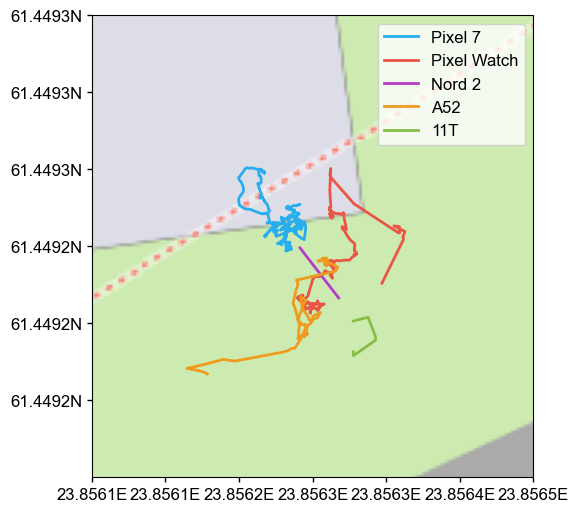

In [8]:
center = ref_enu[:2]
#extent = [center[1] - 0.02, center[1] + 0.005, center[0] - 0.005, center[0] + 0.005]
extent = [center[1] - 0.0002, center[1] + 0.0002, center[0] - 0.0001, center[0] + 0.0001]

locations = {}
for log in logs:
    locations[log.device] = log.fix.loc[log.fix['provider'].isin(['GPS']), ["latitude", "longitude"]]

plotMap(locations=locations, extent=extent, scale=19)

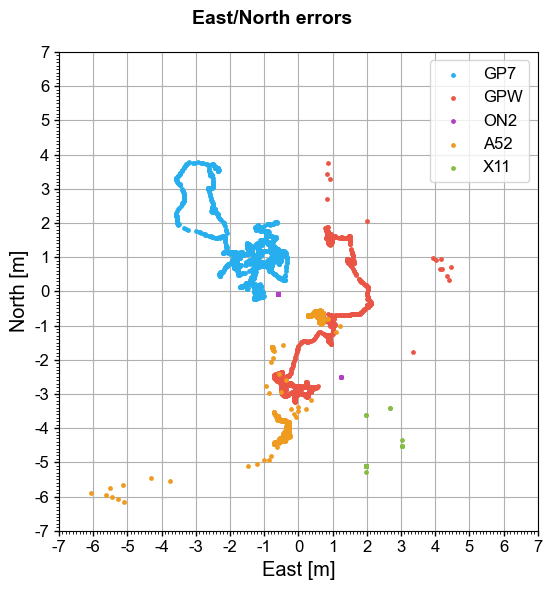

In [9]:
plotEN(logs, lim=7, ticks=[0.1, 1], save=f"{output}/s1_en")

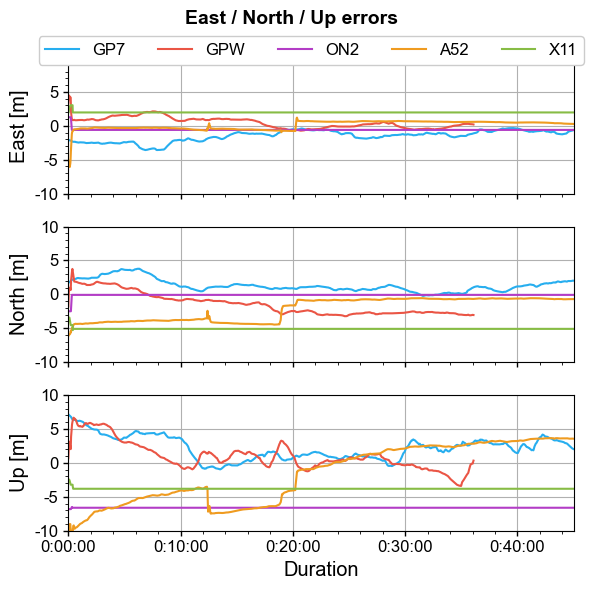

In [10]:
plotENU(logs, lim=[10,10,10], yticks=[1, 5, 1, 5, 1, 5], xticks=[120, 600], save=f"{output}/s1_enu")

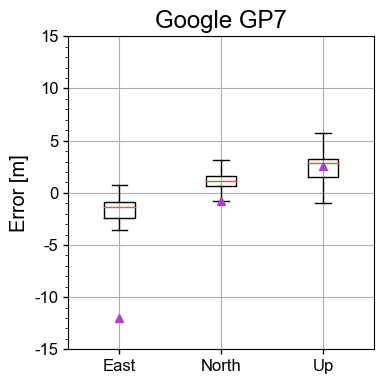

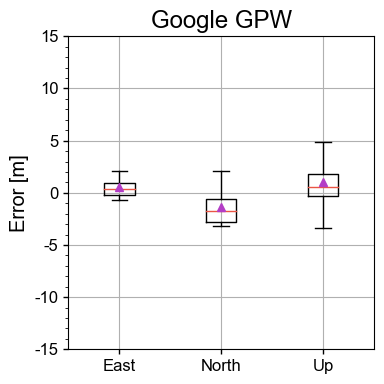

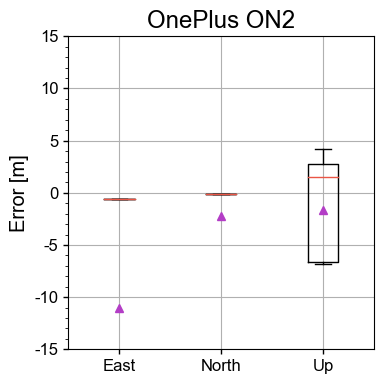

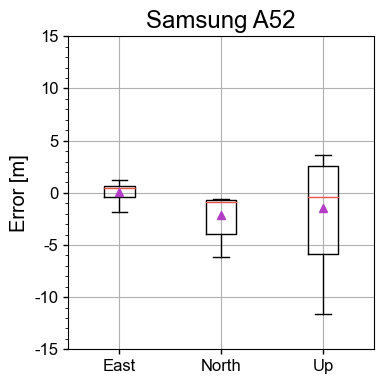

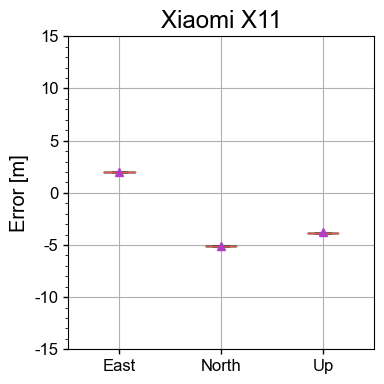

In [11]:
plotStatisticsENU(logs, lim=15, ticks=[1, 5], mode='box')

### Visibility

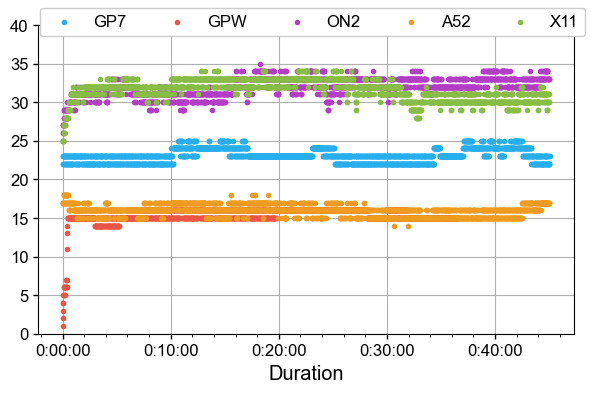

In [12]:
plotTotalSignalsPerEpochs(logs, lim=[0, 40], ticks=[120, 600], mode='signal', save=f"{output}/s1_signals_epoch")

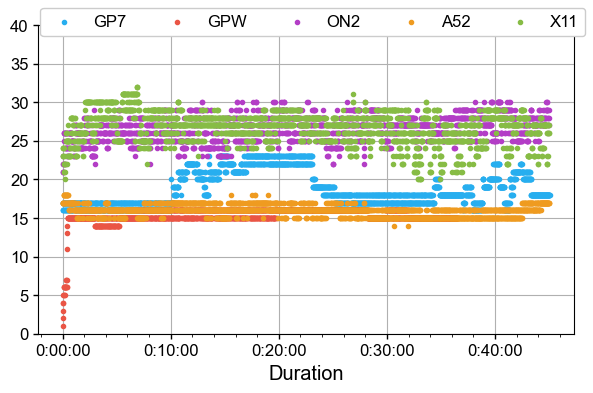

In [13]:
plotTotalSignalsPerEpochs(logs, lim=[0,40], ticks=[120, 600], mode='satellite', save=f"{output}/s1_sats_epoch")

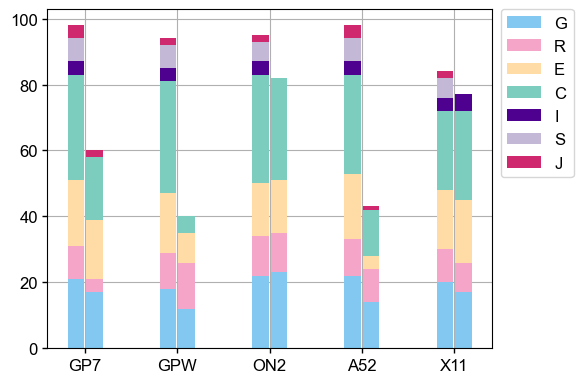

In [14]:
plotBarSignalsPerSystem(logs, save=f"{output}/s1_sats_hist")

In [15]:
df = statsSignalsPerSystem(logs, percent=True)
print(df.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.1f}".format))

\begin{tabular}{lrrrrrrr}
\toprule
device &     G &     R &     E &     C &     I &   S &    J \\
\midrule
   GP7 &  81.0 &  40.0 &  90.0 &  59.4 &   0.0 & 0.0 & 50.0 \\
   GPW &  66.7 & 127.3 &  50.0 &  14.7 &   0.0 & 0.0 &  0.0 \\
   ON2 & 104.5 & 100.0 & 100.0 &  93.9 &   0.0 & 0.0 &  0.0 \\
   A52 &  63.6 &  90.9 &  20.0 &  46.7 &   0.0 & 0.0 & 25.0 \\
   X11 &  85.0 &  90.0 & 105.6 & 112.5 & 125.0 & 0.0 &  0.0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_8264/133727591.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.1f}".format))


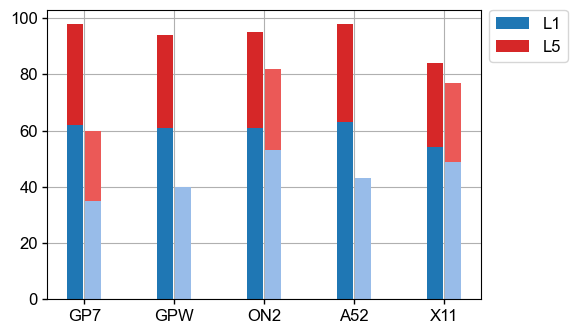

In [16]:
plotBarSignalsPerFrequency(logs, save=f"{output}/s1_freq_hist")

In [17]:
df = statsSignalsPerFrequency(logs, percent=True)
print(df.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.1f}".format))

\begin{tabular}{lrr}
\toprule
device &   L1 &   L5 \\
\midrule
   GP7 & 56.5 & 69.4 \\
   GPW & 65.6 &  0.0 \\
   ON2 & 86.9 & 85.3 \\
   A52 & 68.3 &  0.0 \\
   X11 & 90.7 & 93.3 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_8264/3327316197.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.1f}".format))


Text(0.5, 1.0, 'Time difference between two consecutive signal')

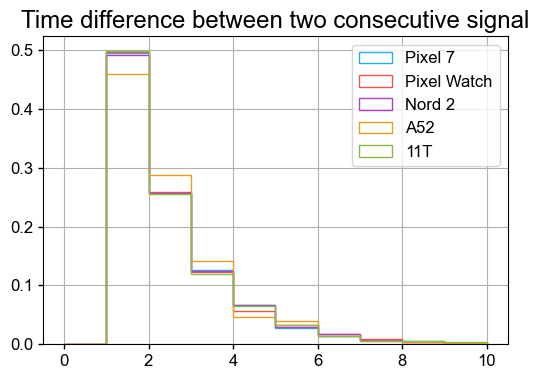

In [18]:
for log in logs:
    dt = log.raw.groupby('prn')['TimeNanos'].diff().values * 1e-9
    plt.hist(dt, range=(0,10), log=False, density=True, histtype='step', label=f"{log.device}")
#plt.ylim([0, 0.6])
plt.legend()
plt.title("Time difference between two consecutive signal")

### Measurements

Pseudoranges

In [19]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    log.raw = misc.filterValues(log.raw, 'PseudorangeAcceleration', 300)
    log.raw[list(misc.GnssState_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['State'], bits=17, type='tracking'), axis='columns', result_type='expand')
    stats.append(log.ref.df['pseudorange_error'].describe(percentiles=[0.5, 0.997]))
stats = pd.concat(stats, keys=device_list, axis=1).T
stats


Rows removed 60   (0.100% -    99.90%)
Rows removed 22   (0.069% -    99.93%)
Rows removed 0    (0.000% -   100.00%)
Rows removed 8    (0.019% -    99.98%)
Rows removed 32   (0.039% -    99.96%)


,count,mean,std,min,50%,99.7%,max
Pixel 7,8061.0,0.061181,1.735686,-108.756947,0.058618,0.174644,108.773149
Pixel Watch,5880.0,0.057538,0.456089,-16.098876,0.051781,0.174666,22.944831
Nord 2,7419.0,0.058572,1.545068,-50.681906,0.043479,0.180419,50.698849
A52,8471.0,0.071726,1.642899,-72.456436,0.061701,0.170534,87.806397
11T,7117.0,0.063235,0.482418,-23.339063,0.063078,0.177228,23.510598


In [20]:
print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))

\begin{tabular}{rrrrrrr}
\toprule
   count &  mean &   std &      min &   50\% &  99.7\% &     max \\
\midrule
8061.000 & 0.061 & 1.736 & -108.757 & 0.059 &  0.175 & 108.773 \\
5880.000 & 0.058 & 0.456 &  -16.099 & 0.052 &  0.175 &  22.945 \\
7419.000 & 0.059 & 1.545 &  -50.682 & 0.043 &  0.180 &  50.699 \\
8471.000 & 0.072 & 1.643 &  -72.456 & 0.062 &  0.171 &  87.806 \\
7117.000 & 0.063 & 0.482 &  -23.339 & 0.063 &  0.177 &  23.511 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_8264/3026797437.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))


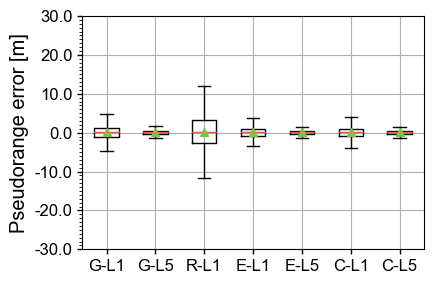

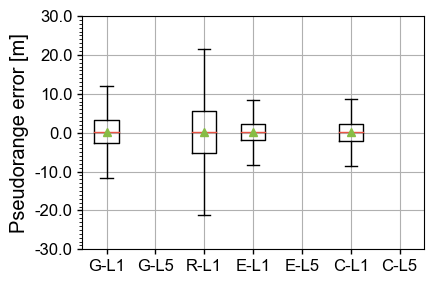

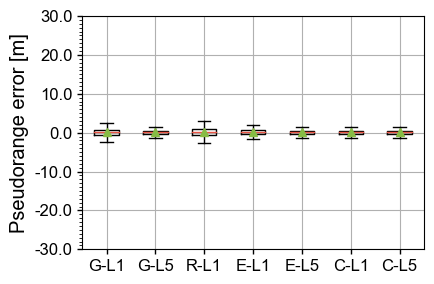

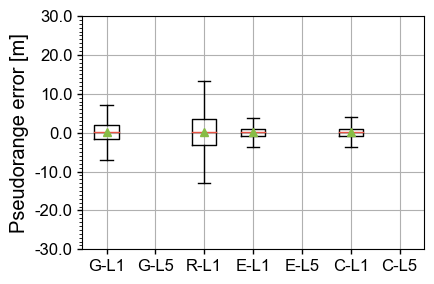

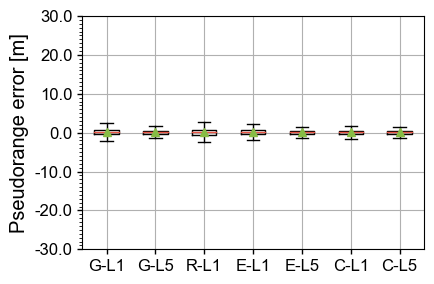

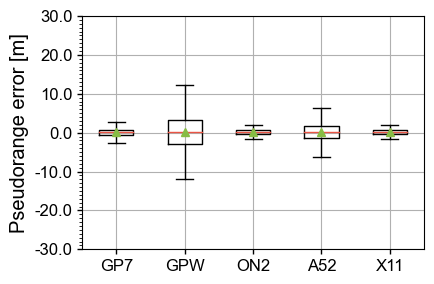

In [21]:

plotStatisticsDataBox(_logs, 
                      'PseudorangeAcceleration', 
                      'Pseudorange error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=30,
                      ticks=[1,10],
                      save=f"{output}/s1_pseudo")

In [22]:

# plotStatisticsDataBox(_logs, 
#                       'pseudorange_error', 
#                       'Pseudorange error [m]', 
#                       ('G', 'R', 'E', 'C'), 
#                       ('L1', 'L5'),
#                       lim=30,
#                       ticks=[1,5],
#                       mode='ref')


In [23]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    log.raw[list(misc.GnssState_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['State'], bits=17, type='tracking'), axis='columns', result_type='expand')
    count = log.raw[list(misc.GnssState_Str.values())].count()
    stats.append(log.raw[list(misc.GnssState_Str.values())].sum().div(count))
stats = pd.concat(stats, keys=device_list, axis=1)
stats

,Pixel 7,Pixel Watch,Nord 2,A52,11T
TRACK_UNKNOWN,0.000000,0.000000,0.000000,0.000000,0.000000
TRACK_CODE_LOCK,0.717620,0.676500,1.000000,1.000000,1.000000
TRACK_BIT_SYNC,0.774944,0.899492,0.647802,1.000000,0.613783
TRACK_SUBFRAME_SYNC,0.492148,0.427083,0.504830,1.000000,0.493431
TRACK_TOW_DECODED,0.342426,0.478859,0.856425,1.000000,0.870979
TRACK_MSEC_AMBIGUOUS,0.000000,0.001314,0.000603,0.000000,0.008669
TRACK_SYMBOL_SYNC,0.774992,0.899612,0.647802,0.000000,0.613783
TRACK_GLO_STRING_SYNC,0.027886,0.298985,0.142971,0.229350,0.120352
TRACK_GLO_TOD_DECODED,0.025661,0.270976,0.142971,0.229350,0.120352
TRACK_BDS_D2_BIT_SYNC,0.000000,0.000000,0.000000,0.000000,0.000000


Doppler

In [24]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    log.raw = misc.filterValues(log.raw, 'DopplerError', 30)
    stats.append(log.raw['DopplerError'].describe(percentiles=[0.5]).T)
stats = pd.concat(stats, keys=device_list, axis=1).T
stats


Rows removed 21   (0.034% -    99.97%)
Rows removed 0    (0.000% -   100.00%)
Rows removed 0    (0.000% -   100.00%)
Rows removed 0    (0.000% -   100.00%)
Rows removed 0    (0.000% -   100.00%)


,count,mean,std,min,50%,max
Pixel 7,62388.0,0.073248,0.252493,-17.606920,0.077572,25.735931
Pixel Watch,33450.0,0.083174,0.160246,-4.161332,0.082897,2.965906
Nord 2,86145.0,0.068761,1.308174,-18.050232,0.096069,15.843781
A52,42983.0,0.085665,1.088187,-17.533207,0.073377,14.831116
11T,85173.0,0.111948,0.910218,-26.402466,0.106386,19.542325


In [25]:
print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))

\begin{tabular}{rrrrrr}
\toprule
    count &  mean &   std &     min &   50\% &    max \\
\midrule
62388.000 & 0.073 & 0.252 & -17.607 & 0.078 & 25.736 \\
33450.000 & 0.083 & 0.160 &  -4.161 & 0.083 &  2.966 \\
86145.000 & 0.069 & 1.308 & -18.050 & 0.096 & 15.844 \\
42983.000 & 0.086 & 1.088 & -17.533 & 0.073 & 14.831 \\
85173.000 & 0.112 & 0.910 & -26.402 & 0.106 & 19.542 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_8264/3026797437.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))


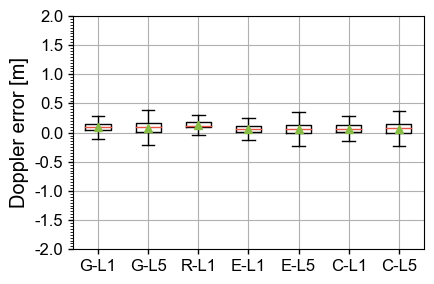

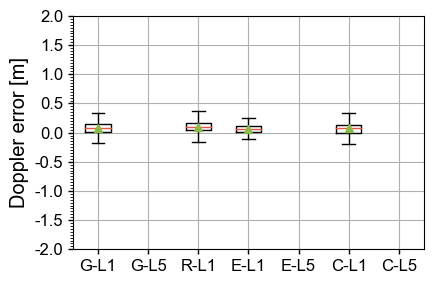

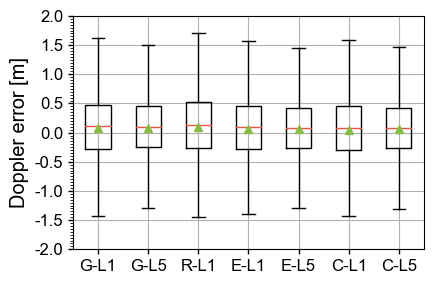

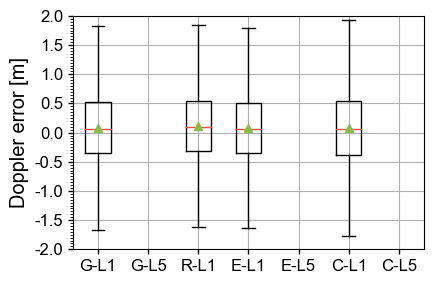

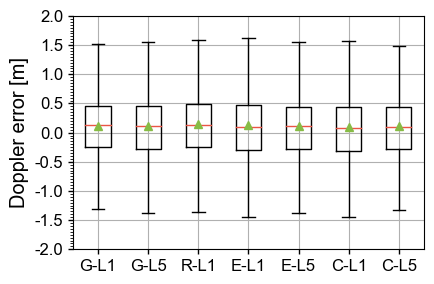

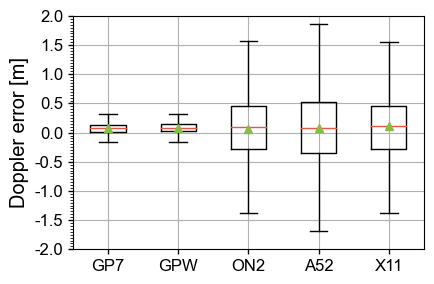

In [26]:
plotStatisticsDataBox(_logs, 
                      'DopplerError', 
                      'Doppler error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5],
                      save=f"{output}/s1_doppler")

In [27]:

# plotStatisticsDataBox(_logs, 
#                       'doppler_error', 
#                       'Doppler error [m]', 
#                       ('G', 'R', 'E', 'C'), 
#                       ('L1', 'L5'),
#                       lim=4,
#                       ticks=[0.05,0.5],
#                       mode='ref')

Phases

In [37]:
_logs = copy.deepcopy(logs)
stats= []
for log in _logs:
    log.raw = misc.filterValues(log.raw, 'PhaseError', 30)
    stats.append(log.raw['PhaseError'].describe(percentiles=[0.5]).T)
stats = pd.concat(stats, keys=device_list, axis=1).T
stats


Rows removed 309  (0.496% -    99.50%)
Rows removed 7    (0.021% -    99.98%)
Rows removed 781  (0.907% -    99.09%)
Rows removed 0    (0.000% -   100.00%)
Rows removed 465  (0.546% -    99.45%)


,count,mean,std,min,50%,max
Pixel 7,62040.0,0.092766,0.747542,-29.154799,0.073671,29.441473
Pixel Watch,33403.0,0.097509,0.327312,-11.921734,0.081774,11.616472
Nord 2,85282.0,0.100421,1.385805,-28.982061,0.086900,29.283376
A52,42941.0,0.000000,0.000000,0.000000,0.000000,0.000000
11T,84633.0,0.136210,1.092311,-29.631899,0.127025,29.967134


In [29]:
print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))

\begin{tabular}{rrrrrr}
\toprule
    count &  mean &   std &     min &   50\% &    max \\
\midrule
62040.000 & 0.093 & 0.748 & -29.155 & 0.074 & 29.441 \\
33403.000 & 0.098 & 0.327 & -11.922 & 0.082 & 11.616 \\
85282.000 & 0.100 & 1.386 & -28.982 & 0.087 & 29.283 \\
42941.000 & 0.000 & 0.000 &   0.000 & 0.000 &  0.000 \\
84633.000 & 0.136 & 1.092 & -29.632 & 0.127 & 29.967 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_8264/3026797437.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))


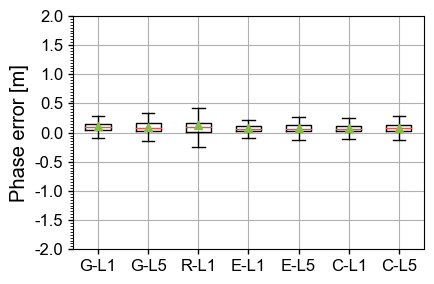

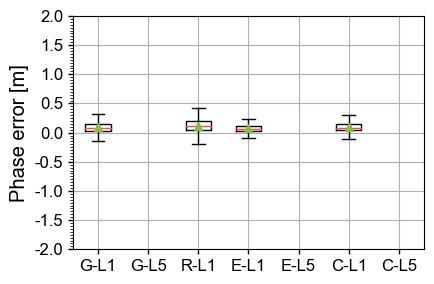

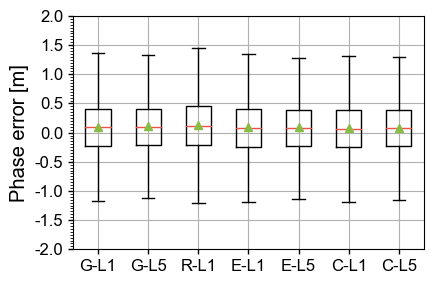

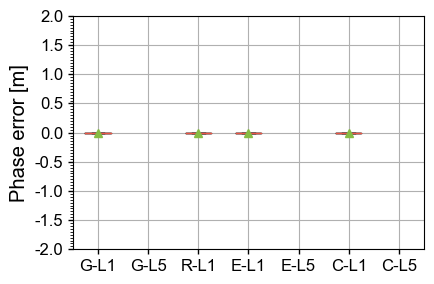

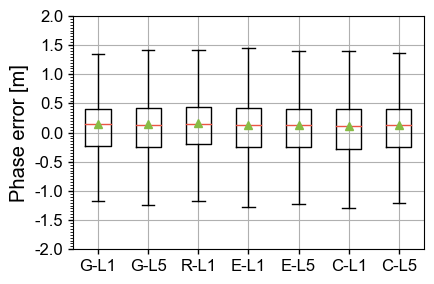

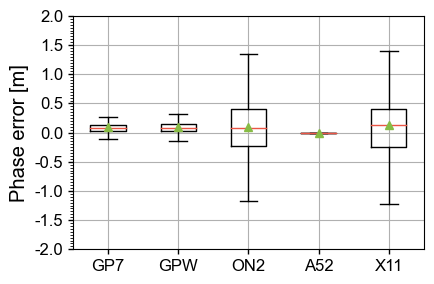

In [30]:
plotStatisticsDataBox(_logs, 
                      'PhaseError', 
                      'Phase error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5],
                      save=f"{output}/s1_phase")
    

In [31]:
# plotStatisticsDataBox(_logs, 
#                       'phase_error', 
#                       'Phase error [m]', 
#                       ('G', 'R', 'E', 'C'), 
#                       ('L1', 'L5'),
#                       lim=2,
#                       ticks=[0.05,0.5],
#                       mode='ref')

In [32]:
stats = []
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw[list(misc.GnssStateADR_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['AccumulatedDeltaRangeState'], bits=5, type='phase'), axis='columns', result_type='expand')
    count = log.raw[list(misc.GnssStateADR_Str.values())].count()
    stats.append(log.raw[list(misc.GnssStateADR_Str.values())].sum().div(count))
stats = pd.concat(stats, keys=device_list, axis=1)
stats

,Pixel 7,Pixel Watch,Nord 2,A52,11T
ADR_UNKNOWN,0.000000,0.000000,0.000000,0.0,0.000000
ADR_VALID,0.767709,0.788325,0.823930,0.0,0.894686
ADR_RESET,0.000000,0.000060,0.000000,0.0,0.000000
ADR_CYCLE_SLIP,0.005667,0.046432,0.078583,0.0,0.152985
ADR_HALF_CYCLE_RESOLVED,0.726440,0.676112,0.777900,0.0,0.815284
ADR_HALF_CYCLE_REPORTED,1.000000,1.000000,1.000000,1.0,1.000000


### C/N0

In [33]:
_logs = copy.deepcopy(logs)
stats= []
for log in _logs:
    stats.append(log.raw['Cn0DbHz'].describe(percentiles=[0.5]).T)
stats = pd.concat(stats, keys=device_list, axis=1).T
stats

,count,mean,std,min,50%,max
Pixel 7,62469.0,30.887581,8.098885,10.6,30.664726,48.215912
Pixel Watch,33490.0,31.588803,6.487278,12.1,32.961893,44.966949
Nord 2,86227.0,28.295252,10.678276,0.0,31.100000,44.707001
A52,43026.0,44.152350,5.457111,21.4,44.700000,56.300000
11T,85250.0,33.864903,6.721695,3.0,35.000000,49.000000


In [34]:
print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))

\begin{tabular}{rrrrrr}
\toprule
    count &   mean &    std &    min &    50\% &    max \\
\midrule
62469.000 & 30.888 &  8.099 & 10.600 & 30.665 & 48.216 \\
33490.000 & 31.589 &  6.487 & 12.100 & 32.962 & 44.967 \\
86227.000 & 28.295 & 10.678 &  0.000 & 31.100 & 44.707 \\
43026.000 & 44.152 &  5.457 & 21.400 & 44.700 & 56.300 \\
85250.000 & 33.865 &  6.722 &  3.000 & 35.000 & 49.000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_8264/3026797437.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))


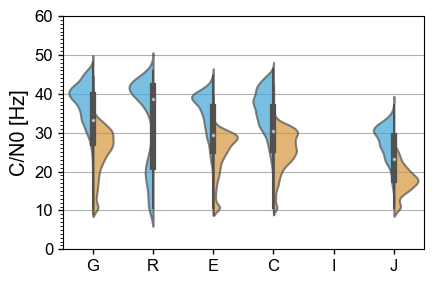

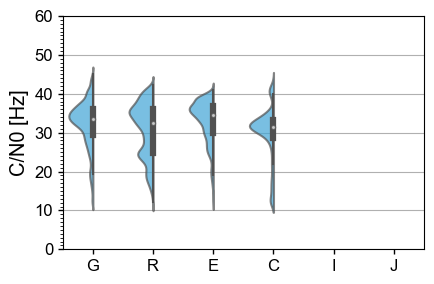

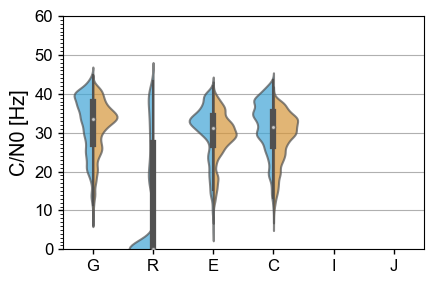

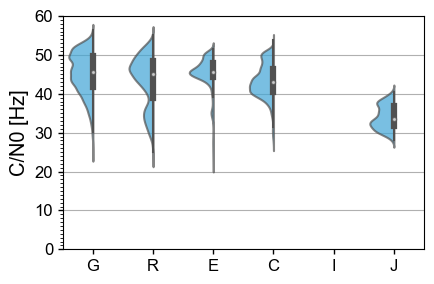

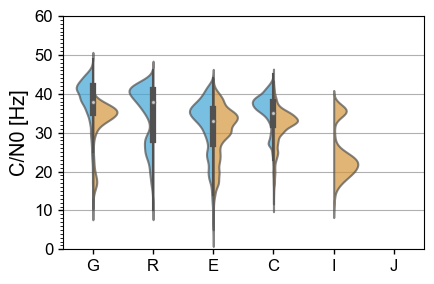

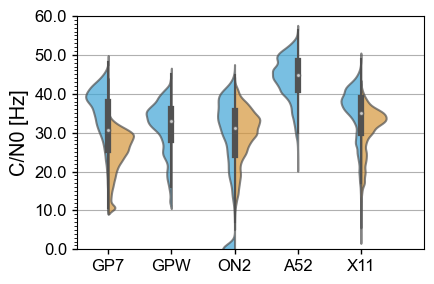

In [35]:
_logs = copy.deepcopy(logs)
plotStatisticsDataViolin(
    _logs, 
    'Cn0DbHz', 
    'C/N0 [Hz]', 
    ('G', 'R', 'E', 'C', 'I', 'J'), 
    ('L1', 'L5'),
    lim=60,
    ticks=[1,10],
    save=f"{output}/s1_cn0")

In [36]:
# plotStatisticsDataViolin(
#     _logs, 
#     'snr', 
#     'C/N0 [Hz]', 
#     ('G', 'R', 'E', 'C', 'I', 'S', 'J'), 
#     ('L1', 'L5'),
#     lim=60,
#     ticks=[1,10],
#     mode='ref')